### Declaração de bibliotecas e suas versões

In [1]:
import logging
import pymc4 as pm # Têm que instalar
import numpy as np
import arviz as az

import tensorflow as tf # Têm que instalar
import tensorflow_probability as tfp # Têm que instalar
import matplotlib.pyplot as plt

#%matplotlib inline

# Print das versões
print(pm.__version__)
print(tf.__version__)
print(tfp.__version__)

# Mute Tensorflow warnings ...
logging.getLogger('tensorflow').setLevel(logging.ERROR)

2021-11-25 21:51:38.376004: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-25 21:51:38.376022: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


4.0a2
2.8.0-dev20211012
0.15.0-dev20211012


In [2]:
# Defenição de um modelo
@pm.model
def model(x):
    # prior for the mean of a normal distribution
    loc = yield pm.Normal('loc', loc=0, scale=10) # loc = media; scale = desvio padrão 
    
    # likelihood of observed data
    obs = yield pm.Normal('obs', loc=loc, scale=1, observed=x)

2021-11-25 21:51:39.741130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-25 21:51:39.741156: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-25 21:51:39.741172: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (talocha): /proc/driver/nvidia/version does not exist
2021-11-25 21:51:39.741546: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<AxesSubplot:title={'center':'model/loc'}>

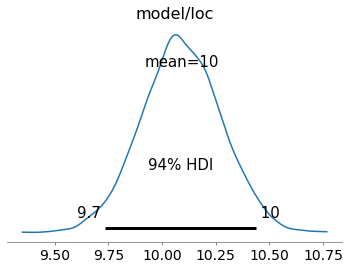

In [3]:
# Criação de 30 pontos de "data", gerados segundo uma distribuição noraml centrada em 3
x = np.random.randn(30) + 10 

# Inferencia
trace = pm.sample(model(x)) # NUTS- No-U-Turn-Sampler

# PLot do gráfico
az.plot_posterior(trace, var_names=["model/loc"])

<AxesSubplot:title={'center':'model/loc'}>

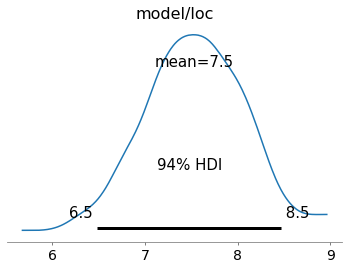

In [4]:
fit = pm.fit(model(x), num_steps=10000, method='advi') #advi method

# Retirar 1000 samples para descobrir a dist. prob. do posterior
trace = fit.approximation.sample(1000)


az.plot_posterior(trace, var_names=['model/loc'])

advi = Automatic Differentiation Variational Inference

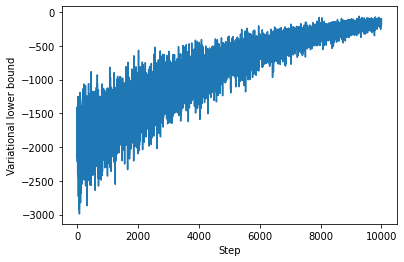

In [5]:
plt.plot(-fit.losses)
plt.ylabel('Variational lower bound')
plt.xlabel('Step');

<AxesSubplot:title={'center':'model/prior/loc'}>

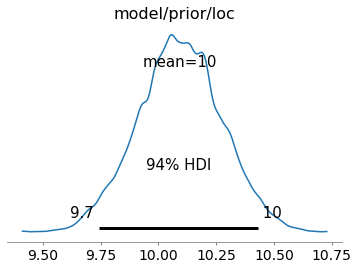

In [6]:
@pm.model
def prior(name, loc=0, scale=10):
    loc = yield pm.Normal(name, loc=loc, scale=scale)
    return loc

@pm.model
def model(x):
    loc = yield prior('loc')
    obs = yield pm.Normal('obs', loc=loc, scale=1, observed=x)
    
trace = pm.sample(model(x))
az.plot_posterior(trace, var_names=['model/prior/loc'])   

#### Criação de um data Set

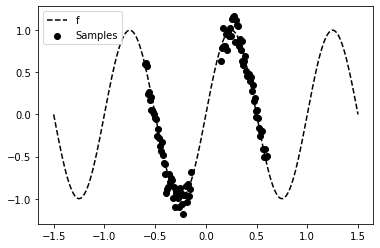

In [7]:
def f(x, noise):
    """Generates noisy samples from a sinusoidal function at x."""
    return np.sin(2 * np.pi * x) + np.random.randn(*x.shape) * noise 

N = 100
noise = 0.1

x1 = np.linspace(-0.6, -0.15, N // 2, dtype=np.float32)
x2 = np.linspace(0.15, 0.6, N // 2, dtype=np.float32)


x = np.concatenate([x1, x2]).reshape(-1, 1) # Passar para a matrix coluna
y = f(x, noise=noise)

x_test = np.linspace(-1.5, 1.5, 200, dtype=np.float32).reshape(-1, 1)
f_test = f(x_test, noise=0.0)

plt.scatter(x, y, marker='o', c='k', label='Samples')
plt.plot(x_test, f_test, 'k--', label='f')
plt.legend();


In [8]:
help(pm.Normal)

Help on class Normal in module pymc4.distributions.continuous:

class Normal(pymc4.distributions.distribution.ContinuousDistribution)
 |  Normal(name, loc, scale, **kwargs)
 |  
 |  Univariate normal random variable.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  The normal distribution can be parameterized either in terms of precision or
 |  standard deviation. The link between the two parametrizations is given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('arviz-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      locs = [0., 0., 0., -2.]
 |      scales = [0.4, 1., 2., 0.4]
 |      for loc, scale in zip(locs, scales):
 |          pdf = st.norm.pdf(x, loc, scale)
 |          p